In [1]:
from __future__ import print_function

In [2]:
import cv2
import numpy as np
import datetime
from keras.models import Model, Sequential
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, rmsprop, adagrad
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils.np_utils import to_categorical
from keras import backend as K

Using TensorFlow backend.


In [3]:
K.set_image_dim_ordering('th')

#original size : 420x580
img_rows=512
img_cols=512

f_size = 3
learning_rate = 1e-2
activation = 'elu'

smooth = 0.1

In [4]:
def load_train_data():
    imgs_train = np.load("../../dataset/ultrasound_nerve_segmentation/X_Train.npy")
    imgs_mask_train = np.load("../../dataset/ultrasound_nerve_segmentation/Y_Train.npy")

    return imgs_train, imgs_mask_train

In [5]:
def load_test_data():
    imgs_test = np.load("../../dataset/ultrasound_nerve_segmentation/X_Test.npy")
    imgs_mask_test = np.load("../../dataset/ultrasound_nerve_segmentation/Y_Test.npy")

    return imgs_test, imgs_mask_test

In [6]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2.* intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [7]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [8]:
def get_unet():
    inputs = Input((1, img_rows, img_cols))
    conv1 = Convolution2D(3, 1, 1, activation=activation, border_mode='same')(inputs)

    conv1 = BatchNormalization()(conv1)
    conv1 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(conv1)
    conv1 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    pool1 = BatchNormalization()(pool1)
    conv2 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    pool2 = BatchNormalization()(pool2)
    conv3 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    pool3 = BatchNormalization()(pool3)
    conv4 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(512, 3, 3, activation=activation, border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation=activation, border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    up6 = BatchNormalization()(up6)
    conv6 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation=activation, border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    up7 = BatchNormalization()(up7)
    conv7 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation=activation, border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    up8 = BatchNormalization()(up8)
    conv8 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation=activation, border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    up9 = BatchNormalization()(up9)
    conv9 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation=activation, border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=[dice_coef])
    model.summary()
    
    return model

In [9]:
def preprocess(X):    
    X = X.reshape(X.shape[0], 1, X.shape[1],X.shape[2])
    Xp = np.ndarray((X.shape[0], X.shape[1], img_rows, img_cols))
    
    for i in range(X.shape[0]):
        Xp[i,0] = cv2.resize(X[i,0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    return Xp

In [10]:
print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)
imgs_train, imgs_mask_train = load_train_data()

------------------------------
Loading and preprocessing train data...
------------------------------


In [11]:
imgs_train = preprocess(imgs_train)
imgs_mask_train = preprocess(imgs_mask_train)

6188


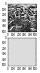

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
ran_idx = random.randint(0, len(imgs_train))
print(ran_idx)
plt.figure(dpi=20)
plt.subplot(211)
plt.imshow(imgs_train[ran_idx,0,:,:],cmap='gray')

plt.subplot(212)
plt.imshow(imgs_mask_train[ran_idx,0,:,:],cmap='gray')

In [10]:
print('-'*30)
print('Creating and compiling model...')
print('-'*30)
model = get_unet()
model_checkpoint = ModelCheckpoint('model_UNET.hdf5', monitor='loss', save_best_only=True)
model_earlystop = EarlyStopping(monitor='loss', min_delta=0.001, patience=2, mode='auto')

------------------------------
Creating and compiling model...
------------------------------
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 512, 512)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 3, 512, 512)   6           input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 3, 512, 512)   2048        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 512, 512)  896         batchnormalization_1[0][0]     

In [14]:
print('-'*30)
print('Fitting model...')
print('-'*30)
model.fit(imgs_train, imgs_mask_train, batch_size=4, nb_epoch=5, verbose=1, shuffle=True,
          callbacks=[model_checkpoint, model_earlystop])

------------------------------
Fitting model...
------------------------------
Epoch 1/5
9016/9016 [==============================] - 4181s - loss: -0.7128 - dice_coef: 0.7128      

In [15]:
print('-'*30)
print('Loading and preprocessing test data...')
print('-'*30)
imgs_test, imgs_id_test = load_test_data()
imgs_test = preprocess(imgs_test)
imgs_id_test = preprocess(imgs_id_test)

------------------------------
Loading and preprocessing test data...
------------------------------


In [16]:
print('-'*30)
print('Loading saved weights...')
print('-'*30)
model.load_weights('model_UNET.hdf5')

print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
imgs_mask_test = model.predict(imgs_test, verbose=1, batch_size=8)
# np.save('imgs_mask_test.npy', imgs_mask_test)

------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
2254/2254 [==============================] - 435s     

In [18]:
loss, metric = model.evaluate(imgs_test, imgs_id_test, batch_size=8, verbose=1)

2254/2254 [==============================] - 410s     

In [19]:
print("loss:{}, metric:{}".format(loss, metric))

loss:-0.734491495401, metric:0.734491495242
